In [155]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plot
import numpy.matlib
import math

In [156]:
# Accessing MNIST dataset with tensorflow
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images, test_images = training_images / 255.0, test_images / 255.0

In [157]:
def relu(x):
    return np.maximum(0, x)

In [158]:
def relu_deriv(x):
    return np.where(x < 0, 0, 1)

In [159]:
def display_images(images, labels, num_images = 10):
    figure, axes = plot.subplots(1, num_images, figsize = (20, 2)) # 1 row, num_images number of columns
    for i in range(num_images):
        axes[i].imshow(images[i], cmap = 'gray')
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plot.tight_layout()
    plot.show()

In [160]:
class Perceptron():
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.weights = [np.random.uniform(0, 1, (layer_sizes[i + 1], layer_sizes[i])) for i in range(len(layer_sizes) - 1)]       # creates list of matrices; layer_sizes[i]+1 for bias
        for i in range(len(self.layer_sizes) - 1):                                                                                          # Normalises weights
            self.weights[i] = np.divide(self.weights[i],np.matlib.repmat(np.sum(self.weights[i],1)[:,None],1,self.layer_sizes[i]))
        self.weighted_sums = [np.zeros(layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)]                        # i+1 for same reason as above
        self.activations = [np.zeros(layer_sizes[i]) for i in range(len(layer_sizes))]                                  # +1 for bias
    
    def forward_propagate(self, input_activations):                                                 # input_activations is a vector
        self.activations[0][:self.layer_sizes[0] - 1] = input_activations                           # Initialises the input activations as first element in a list of activations for each layer
        self.activations[0][-1] = 1
        for i in range(len(self.layer_sizes) - 1):
            self.weighted_sums[i] = np.dot(self.weights[i], self.activations[i])                    # Bias included as neuron with activation 1 in input layer
            self.activations[i + 1] = relu(self.weighted_sums[i])                                   # i+1 because activations includes input layer wheareas others don't; ideally for readability, activations index would be 1 less than weights and biases 
    
    def calculate_cost(self, desired_activations):                                                  # Calculates cost of one image
        return 0.5 * np.sum(np.square(self.activations[-1] - desired_activations))

    def back_propagate(self, desired_activations):                                                                                  # Calculates gradients for weights
        weights_gradient = [np.zeros(self.weights[i].shape) for i in range(len(self.layer_sizes) - 1)]     # Same shape as weights
        error = desired_activations - self.activations[-1]

        for i in range(len(self.layer_sizes) - 2, -1, -1):                      # Iterates from last layer to first layer
            delta = relu_deriv(self.weighted_sums[i]) * error        # Previously self.weighted_sums[i].reshape(-1, 1)
            weights_gradient = np.outer(delta, self.activations[i])              # Should result in a matrix (first, dot product between a row and column vector, then element-wise multiplication)
            
        return weights_gradient
        
    def adjust_parameters(self, mean_weights_gradient, learning_rate):       # Shift weights and biases according to gradient
        for i in range(len(self.layer_sizes) - 1):
            self.weights[i] -= learning_rate * mean_weights_gradient[i]

    def test_model(self):
        incorrect_classifications = 0
        for i in range(100):
            self.forward_propagate(test_images[i].flatten())
            if np.argmax(self.activations[-1]) != test_labels[i]:
                incorrect_classifications += 1
        
        return incorrect_classifications

In [161]:
LAYER_SIZES = [785, 10]
LEARNING_RATE = 0.001
NUM_SAMPLES = 60000     
BATCH_SIZE = 20
NUM_BATCHES = int(math.floor(NUM_SAMPLES / BATCH_SIZE))
NUM_EPOCHS = 10

In [162]:
perceptron = Perceptron(LAYER_SIZES)

sample_weights_gradient = [np.zeros(perceptron.weights[i].shape) for i in range (len(LAYER_SIZES) - 1)]
mean_weights_gradient = [np.zeros(perceptron.weights[i].shape) for i in range(len(LAYER_SIZES) - 1)]

costs = []
# percentage_error = []

In [163]:
for i in range(NUM_EPOCHS):
    epoch_cost = 0

    for batch in range(NUM_BATCHES):
        mean_weights_gradient = [np.zeros(perceptron.weights[i].shape) for i in range(len(LAYER_SIZES) - 1)]   # reset mean weights gradient

        
        for j in range(BATCH_SIZE):
            index = BATCH_SIZE * batch + j
            perceptron.forward_propagate(training_images[index].flatten())

            desired_activations = np.zeros(LAYER_SIZES[-1])                             # Initialises a vector with the size of the number of output nodes
            desired_activations[training_labels[index]] = 1.0

            epoch_cost += perceptron.calculate_cost(desired_activations) / NUM_SAMPLES        # Cost per epoch

            sample_weights_gradient = perceptron.back_propagate(desired_activations)

            for k in range(len(LAYER_SIZES) - 1):                                       # For each layer apart from input layer, iteratively update mean gradient
                mean_weights_gradient[k] += sample_weights_gradient[k] / BATCH_SIZE
            
            if i % BATCH_SIZE == 0 and i != 0:
                perceptron.adjust_parameters(mean_weights_gradient, LEARNING_RATE)
                

        perceptron.adjust_parameters(mean_weights_gradient, LEARNING_RATE)
    costs.append(epoch_cost)
    print(epoch_cost)
    #percentage_error.append(perceptron.test_model())
    #print(percentage_error[m])

1.5707229151141272e+95
1.479585077612892e+195
1.393735318196261e+295


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/var/folders/jd/bpt85r9d2sx4bggpw3wbs6k00000gn/T/ipykernel_77793/1372118435.py:18: RuntimeWarning: overflow encountered in square
  return np.sum(np.square(self.activations[-1] - desired_activations))


inf


KeyboardInterrupt: 

In [ ]:
#for i in range(10):
#    perceptron.forward_propagate(test_images[i].flatten())
#    print(perceptron.activations[-1])
#    # print(np.argmax(perceptron.activations[-1]))

# display_images(test_images, test_labels)

Text(0.5, 1.0, 'Average error per epoch')

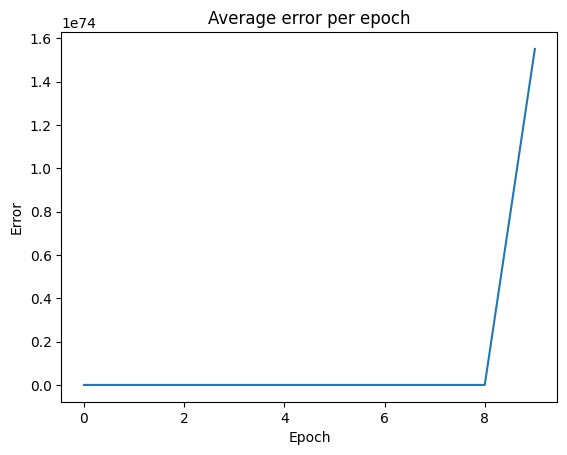

In [ ]:
plot.plot(costs)
plot.xlabel('Epoch')
plot.ylabel('Error')
plot.title('Average error per epoch')